# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [22]:
#
!nvidia-smi

Sun Jun  1 20:39:22 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.36       Driver Version: 512.36       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0    26W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

D:\anaconda\envs\torchEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [2]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [3]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
train_data.shape

(10000, 50, 110, 6)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [7]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [8]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=256, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [10]:
# # model = LinearRegressionModel().to(device)
# # model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)

# optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# early_stopping_patience = 10
# best_val_loss = float('inf')
# no_improvement = 0
# criterion = nn.MSELoss()

In [11]:
#Modified

# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTM().to(device)
# model = GRU().to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75) # You can try different schedulers
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-3, total_steps=100)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

early_stopping_patience = 10
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [12]:
train_mae_list = []
val_mae_list = []
epoch_list = []

for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    train_mae = 0
    
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
        
        with torch.no_grad():
            pred_un = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y_un = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            train_mae += nn.L1Loss()(pred_un, y_un).item()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step(val_loss)
    # scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)
    epoch_list.append(epoch)

    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   1%|▋                                                                       | 1/100 [00:16<27:36, 16.74s/epoch]

Epoch 000 | Learning rate 0.002000 | train normalized MSE   0.9789 | val normalized MSE   0.4412, | val MAE   2.6219 | val MSE  21.6175


Epoch:   2%|█▍                                                                      | 2/100 [00:24<18:37, 11.40s/epoch]

Epoch 001 | Learning rate 0.002000 | train normalized MSE   0.4033 | val normalized MSE   0.3649, | val MAE   2.2540 | val MSE  17.8804


Epoch:   3%|██▏                                                                     | 3/100 [00:31<15:36,  9.66s/epoch]

Epoch 002 | Learning rate 0.002000 | train normalized MSE   0.3553 | val normalized MSE   0.3391, | val MAE   2.3206 | val MSE  16.6156


Epoch:   4%|██▉                                                                     | 4/100 [00:39<14:15,  8.91s/epoch]

Epoch 003 | Learning rate 0.002000 | train normalized MSE   0.3288 | val normalized MSE   0.3140, | val MAE   2.1553 | val MSE  15.3835


Epoch:   5%|███▌                                                                    | 5/100 [00:47<13:26,  8.49s/epoch]

Epoch 004 | Learning rate 0.002000 | train normalized MSE   0.3122 | val normalized MSE   0.3229, | val MAE   2.1755 | val MSE  15.8229


Epoch:   6%|████▎                                                                   | 6/100 [00:55<12:53,  8.23s/epoch]

Epoch 005 | Learning rate 0.002000 | train normalized MSE   0.2838 | val normalized MSE   0.2454, | val MAE   1.7257 | val MSE  12.0259


Epoch:   7%|█████                                                                   | 7/100 [01:03<13:01,  8.40s/epoch]

Epoch 006 | Learning rate 0.002000 | train normalized MSE   0.2695 | val normalized MSE   0.2531, | val MAE   1.8463 | val MSE  12.4030


Epoch:   8%|█████▊                                                                  | 8/100 [01:11<12:36,  8.23s/epoch]

Epoch 007 | Learning rate 0.002000 | train normalized MSE   0.2657 | val normalized MSE   0.2378, | val MAE   1.7375 | val MSE  11.6519


Epoch:   9%|██████▍                                                                 | 9/100 [01:19<12:17,  8.10s/epoch]

Epoch 008 | Learning rate 0.002000 | train normalized MSE   0.2576 | val normalized MSE   0.2361, | val MAE   1.7371 | val MSE  11.5706


Epoch:  10%|███████                                                                | 10/100 [01:27<12:00,  8.01s/epoch]

Epoch 009 | Learning rate 0.002000 | train normalized MSE   0.2508 | val normalized MSE   0.2248, | val MAE   1.7188 | val MSE  11.0137


Epoch:  11%|███████▊                                                               | 11/100 [01:35<11:46,  7.94s/epoch]

Epoch 010 | Learning rate 0.002000 | train normalized MSE   0.2494 | val normalized MSE   0.2227, | val MAE   1.7586 | val MSE  10.9142


Epoch:  12%|████████▌                                                              | 12/100 [01:43<11:35,  7.91s/epoch]

Epoch 011 | Learning rate 0.002000 | train normalized MSE   0.2414 | val normalized MSE   0.2436, | val MAE   1.8107 | val MSE  11.9363


Epoch:  13%|█████████▏                                                             | 13/100 [01:50<11:25,  7.88s/epoch]

Epoch 012 | Learning rate 0.002000 | train normalized MSE   0.2406 | val normalized MSE   0.2115, | val MAE   1.5917 | val MSE  10.3639


Epoch:  14%|█████████▉                                                             | 14/100 [01:58<11:20,  7.91s/epoch]

Epoch 013 | Learning rate 0.002000 | train normalized MSE   0.2358 | val normalized MSE   0.2127, | val MAE   1.5692 | val MSE  10.4228


Epoch:  15%|██████████▋                                                            | 15/100 [02:06<11:12,  7.91s/epoch]

Epoch 014 | Learning rate 0.002000 | train normalized MSE   0.2306 | val normalized MSE   0.2075, | val MAE   1.5963 | val MSE  10.1668


Epoch:  16%|███████████▎                                                           | 16/100 [02:14<11:06,  7.93s/epoch]

Epoch 015 | Learning rate 0.002000 | train normalized MSE   0.2304 | val normalized MSE   0.2385, | val MAE   1.8315 | val MSE  11.6843


Epoch:  17%|████████████                                                           | 17/100 [02:22<10:58,  7.93s/epoch]

Epoch 016 | Learning rate 0.002000 | train normalized MSE   0.2289 | val normalized MSE   0.2010, | val MAE   1.5788 | val MSE   9.8465


Epoch:  18%|████████████▊                                                          | 18/100 [02:30<10:47,  7.89s/epoch]

Epoch 017 | Learning rate 0.002000 | train normalized MSE   0.2257 | val normalized MSE   0.2071, | val MAE   1.6017 | val MSE  10.1466


Epoch:  19%|█████████████▍                                                         | 19/100 [02:38<10:37,  7.86s/epoch]

Epoch 018 | Learning rate 0.002000 | train normalized MSE   0.2247 | val normalized MSE   0.1946, | val MAE   1.5574 | val MSE   9.5335


Epoch:  20%|██████████████▏                                                        | 20/100 [02:45<10:23,  7.79s/epoch]

Epoch 019 | Learning rate 0.002000 | train normalized MSE   0.2232 | val normalized MSE   0.2118, | val MAE   1.6994 | val MSE  10.3782


Epoch:  21%|██████████████▉                                                        | 21/100 [02:53<10:12,  7.76s/epoch]

Epoch 020 | Learning rate 0.002000 | train normalized MSE   0.2192 | val normalized MSE   0.2054, | val MAE   1.6786 | val MSE  10.0642


Epoch:  22%|███████████████▌                                                       | 22/100 [03:01<10:02,  7.73s/epoch]

Epoch 021 | Learning rate 0.002000 | train normalized MSE   0.2180 | val normalized MSE   0.2079, | val MAE   1.6486 | val MSE  10.1869


Epoch:  23%|████████████████▎                                                      | 23/100 [03:08<09:53,  7.71s/epoch]

Epoch 022 | Learning rate 0.002000 | train normalized MSE   0.2142 | val normalized MSE   0.1945, | val MAE   1.5357 | val MSE   9.5301


Epoch:  24%|█████████████████                                                      | 24/100 [03:16<09:45,  7.70s/epoch]

Epoch 023 | Learning rate 0.002000 | train normalized MSE   0.2174 | val normalized MSE   0.1918, | val MAE   1.5142 | val MSE   9.3978


Epoch:  25%|█████████████████▊                                                     | 25/100 [03:24<09:37,  7.70s/epoch]

Epoch 024 | Learning rate 0.002000 | train normalized MSE   0.2173 | val normalized MSE   0.2095, | val MAE   1.7136 | val MSE  10.2678


Epoch:  26%|██████████████████▍                                                    | 26/100 [03:31<09:28,  7.69s/epoch]

Epoch 025 | Learning rate 0.002000 | train normalized MSE   0.2147 | val normalized MSE   0.2264, | val MAE   1.8074 | val MSE  11.0957


Epoch:  27%|███████████████████▏                                                   | 27/100 [03:39<09:20,  7.67s/epoch]

Epoch 026 | Learning rate 0.002000 | train normalized MSE   0.2122 | val normalized MSE   0.2055, | val MAE   1.6958 | val MSE  10.0713


Epoch:  28%|███████████████████▉                                                   | 28/100 [03:47<09:11,  7.66s/epoch]

Epoch 027 | Learning rate 0.001000 | train normalized MSE   0.2050 | val normalized MSE   0.2004, | val MAE   1.5388 | val MSE   9.8193


Epoch:  29%|████████████████████▌                                                  | 29/100 [03:54<09:04,  7.67s/epoch]

Epoch 028 | Learning rate 0.001000 | train normalized MSE   0.1958 | val normalized MSE   0.1806, | val MAE   1.3985 | val MSE   8.8513


Epoch:  30%|█████████████████████▎                                                 | 30/100 [04:02<08:57,  7.68s/epoch]

Epoch 029 | Learning rate 0.001000 | train normalized MSE   0.1924 | val normalized MSE   0.1916, | val MAE   1.5240 | val MSE   9.3897


Epoch:  31%|██████████████████████                                                 | 31/100 [04:10<08:52,  7.71s/epoch]

Epoch 030 | Learning rate 0.001000 | train normalized MSE   0.1919 | val normalized MSE   0.1829, | val MAE   1.4666 | val MSE   8.9609


Epoch:  32%|██████████████████████▋                                                | 32/100 [04:18<08:46,  7.75s/epoch]

Epoch 031 | Learning rate 0.001000 | train normalized MSE   0.1909 | val normalized MSE   0.1851, | val MAE   1.4927 | val MSE   9.0713


Epoch:  33%|███████████████████████▍                                               | 33/100 [04:26<08:43,  7.81s/epoch]

Epoch 032 | Learning rate 0.000500 | train normalized MSE   0.1908 | val normalized MSE   0.1807, | val MAE   1.4484 | val MSE   8.8532


Epoch:  34%|████████████████████████▏                                              | 34/100 [04:34<08:37,  7.84s/epoch]

Epoch 033 | Learning rate 0.000500 | train normalized MSE   0.1806 | val normalized MSE   0.1784, | val MAE   1.3988 | val MSE   8.7438


Epoch:  35%|████████████████████████▊                                              | 35/100 [04:41<08:28,  7.82s/epoch]

Epoch 034 | Learning rate 0.000500 | train normalized MSE   0.1810 | val normalized MSE   0.1760, | val MAE   1.3989 | val MSE   8.6243


Epoch:  36%|█████████████████████████▌                                             | 36/100 [04:49<08:19,  7.81s/epoch]

Epoch 035 | Learning rate 0.000500 | train normalized MSE   0.1797 | val normalized MSE   0.1802, | val MAE   1.4538 | val MSE   8.8317


Epoch:  37%|██████████████████████████▎                                            | 37/100 [04:57<08:12,  7.82s/epoch]

Epoch 036 | Learning rate 0.000500 | train normalized MSE   0.1820 | val normalized MSE   0.1797, | val MAE   1.4208 | val MSE   8.8044


Epoch:  38%|██████████████████████████▉                                            | 38/100 [05:05<08:05,  7.82s/epoch]

Epoch 037 | Learning rate 0.000500 | train normalized MSE   0.1804 | val normalized MSE   0.1762, | val MAE   1.4071 | val MSE   8.6325


Epoch:  39%|███████████████████████████▋                                           | 39/100 [05:13<07:56,  7.82s/epoch]

Epoch 038 | Learning rate 0.000500 | train normalized MSE   0.1796 | val normalized MSE   0.1749, | val MAE   1.3999 | val MSE   8.5707


Epoch:  40%|████████████████████████████▍                                          | 40/100 [05:21<07:50,  7.84s/epoch]

Epoch 039 | Learning rate 0.000500 | train normalized MSE   0.1785 | val normalized MSE   0.1754, | val MAE   1.4078 | val MSE   8.5928


Epoch:  41%|█████████████████████████████                                          | 41/100 [05:28<07:42,  7.84s/epoch]

Epoch 040 | Learning rate 0.000500 | train normalized MSE   0.1788 | val normalized MSE   0.1782, | val MAE   1.4093 | val MSE   8.7298


Epoch:  42%|█████████████████████████████▊                                         | 42/100 [05:36<07:35,  7.85s/epoch]

Epoch 041 | Learning rate 0.000500 | train normalized MSE   0.1781 | val normalized MSE   0.1801, | val MAE   1.4445 | val MSE   8.8266


Epoch:  43%|██████████████████████████████▌                                        | 43/100 [05:44<07:27,  7.86s/epoch]

Epoch 042 | Learning rate 0.000500 | train normalized MSE   0.1771 | val normalized MSE   0.1740, | val MAE   1.3502 | val MSE   8.5249


Epoch:  44%|███████████████████████████████▏                                       | 44/100 [05:52<07:21,  7.89s/epoch]

Epoch 043 | Learning rate 0.000500 | train normalized MSE   0.1765 | val normalized MSE   0.1822, | val MAE   1.4609 | val MSE   8.9280


Epoch:  45%|███████████████████████████████▉                                       | 45/100 [06:00<07:13,  7.89s/epoch]

Epoch 044 | Learning rate 0.000500 | train normalized MSE   0.1758 | val normalized MSE   0.1757, | val MAE   1.4029 | val MSE   8.6099


Epoch:  46%|████████████████████████████████▋                                      | 46/100 [06:08<07:04,  7.87s/epoch]

Epoch 045 | Learning rate 0.000500 | train normalized MSE   0.1778 | val normalized MSE   0.1771, | val MAE   1.4340 | val MSE   8.6771


Epoch:  47%|█████████████████████████████████▎                                     | 47/100 [06:16<06:58,  7.89s/epoch]

Epoch 046 | Learning rate 0.000250 | train normalized MSE   0.1756 | val normalized MSE   0.1795, | val MAE   1.4178 | val MSE   8.7946


Epoch:  48%|██████████████████████████████████                                     | 48/100 [06:24<06:50,  7.90s/epoch]

Epoch 047 | Learning rate 0.000250 | train normalized MSE   0.1727 | val normalized MSE   0.1708, | val MAE   1.3669 | val MSE   8.3684


Epoch:  49%|██████████████████████████████████▊                                    | 49/100 [06:32<06:42,  7.90s/epoch]

Epoch 048 | Learning rate 0.000250 | train normalized MSE   0.1709 | val normalized MSE   0.1712, | val MAE   1.3495 | val MSE   8.3873


Epoch:  50%|███████████████████████████████████▌                                   | 50/100 [06:39<06:34,  7.89s/epoch]

Epoch 049 | Learning rate 0.000250 | train normalized MSE   0.1689 | val normalized MSE   0.1684, | val MAE   1.3473 | val MSE   8.2527


Epoch:  51%|████████████████████████████████████▏                                  | 51/100 [06:47<06:25,  7.88s/epoch]

Epoch 050 | Learning rate 0.000250 | train normalized MSE   0.1703 | val normalized MSE   0.1725, | val MAE   1.3940 | val MSE   8.4540


Epoch:  52%|████████████████████████████████████▉                                  | 52/100 [06:55<06:16,  7.84s/epoch]

Epoch 051 | Learning rate 0.000250 | train normalized MSE   0.1696 | val normalized MSE   0.1675, | val MAE   1.3281 | val MSE   8.2081


Epoch:  53%|█████████████████████████████████████▋                                 | 53/100 [07:03<06:08,  7.84s/epoch]

Epoch 052 | Learning rate 0.000250 | train normalized MSE   0.1699 | val normalized MSE   0.1706, | val MAE   1.3613 | val MSE   8.3572


Epoch:  54%|██████████████████████████████████████▎                                | 54/100 [07:11<06:00,  7.84s/epoch]

Epoch 053 | Learning rate 0.000250 | train normalized MSE   0.1677 | val normalized MSE   0.1760, | val MAE   1.3993 | val MSE   8.6218


Epoch:  55%|███████████████████████████████████████                                | 55/100 [07:19<05:53,  7.85s/epoch]

Epoch 054 | Learning rate 0.000250 | train normalized MSE   0.1688 | val normalized MSE   0.1696, | val MAE   1.3255 | val MSE   8.3116


Epoch:  56%|███████████████████████████████████████▊                               | 56/100 [07:26<05:44,  7.83s/epoch]

Epoch 055 | Learning rate 0.000125 | train normalized MSE   0.1688 | val normalized MSE   0.1703, | val MAE   1.3381 | val MSE   8.3440


Epoch:  57%|████████████████████████████████████████▍                              | 57/100 [07:34<05:35,  7.81s/epoch]

Epoch 056 | Learning rate 0.000125 | train normalized MSE   0.1655 | val normalized MSE   0.1689, | val MAE   1.3359 | val MSE   8.2765


Epoch:  58%|█████████████████████████████████████████▏                             | 58/100 [07:42<05:28,  7.83s/epoch]

Epoch 057 | Learning rate 0.000125 | train normalized MSE   0.1647 | val normalized MSE   0.1677, | val MAE   1.3289 | val MSE   8.2190


Epoch:  59%|█████████████████████████████████████████▉                             | 59/100 [07:50<05:22,  7.86s/epoch]

Epoch 058 | Learning rate 0.000125 | train normalized MSE   0.1646 | val normalized MSE   0.1674, | val MAE   1.3237 | val MSE   8.2037


Epoch:  60%|██████████████████████████████████████████▌                            | 60/100 [07:58<05:15,  7.88s/epoch]

Epoch 059 | Learning rate 0.000125 | train normalized MSE   0.1637 | val normalized MSE   0.1668, | val MAE   1.3216 | val MSE   8.1720


Epoch:  61%|███████████████████████████████████████████▎                           | 61/100 [08:06<05:08,  7.92s/epoch]

Epoch 060 | Learning rate 0.000125 | train normalized MSE   0.1637 | val normalized MSE   0.1700, | val MAE   1.3299 | val MSE   8.3306


Epoch:  62%|████████████████████████████████████████████                           | 62/100 [08:14<05:02,  7.95s/epoch]

Epoch 061 | Learning rate 0.000125 | train normalized MSE   0.1650 | val normalized MSE   0.1671, | val MAE   1.3087 | val MSE   8.1883


Epoch:  63%|████████████████████████████████████████████▋                          | 63/100 [08:22<04:53,  7.94s/epoch]

Epoch 062 | Learning rate 0.000125 | train normalized MSE   0.1634 | val normalized MSE   0.1703, | val MAE   1.3510 | val MSE   8.3447


Epoch:  64%|█████████████████████████████████████████████▍                         | 64/100 [08:30<04:45,  7.93s/epoch]

Epoch 063 | Learning rate 0.000125 | train normalized MSE   0.1643 | val normalized MSE   0.1664, | val MAE   1.3191 | val MSE   8.1513


Epoch:  65%|██████████████████████████████████████████████▏                        | 65/100 [08:38<04:37,  7.94s/epoch]

Epoch 064 | Learning rate 0.000125 | train normalized MSE   0.1641 | val normalized MSE   0.1668, | val MAE   1.3029 | val MSE   8.1709


Epoch:  66%|██████████████████████████████████████████████▊                        | 66/100 [08:45<04:28,  7.90s/epoch]

Epoch 065 | Learning rate 0.000125 | train normalized MSE   0.1631 | val normalized MSE   0.1663, | val MAE   1.3245 | val MSE   8.1504


Epoch:  67%|███████████████████████████████████████████████▌                       | 67/100 [08:53<04:19,  7.87s/epoch]

Epoch 066 | Learning rate 0.000125 | train normalized MSE   0.1631 | val normalized MSE   0.1645, | val MAE   1.2944 | val MSE   8.0616


Epoch:  68%|████████████████████████████████████████████████▎                      | 68/100 [09:01<04:12,  7.88s/epoch]

Epoch 067 | Learning rate 0.000125 | train normalized MSE   0.1639 | val normalized MSE   0.1659, | val MAE   1.3320 | val MSE   8.1280


Epoch:  69%|████████████████████████████████████████████████▉                      | 69/100 [09:09<04:05,  7.91s/epoch]

Epoch 068 | Learning rate 0.000125 | train normalized MSE   0.1636 | val normalized MSE   0.1649, | val MAE   1.3063 | val MSE   8.0779


Epoch:  70%|█████████████████████████████████████████████████▋                     | 70/100 [09:17<03:55,  7.86s/epoch]

Epoch 069 | Learning rate 0.000125 | train normalized MSE   0.1635 | val normalized MSE   0.1654, | val MAE   1.3148 | val MSE   8.1050


Epoch:  71%|██████████████████████████████████████████████████▍                    | 71/100 [09:25<03:49,  7.90s/epoch]

Epoch 070 | Learning rate 0.000063 | train normalized MSE   0.1626 | val normalized MSE   0.1660, | val MAE   1.3107 | val MSE   8.1321


Epoch:  72%|███████████████████████████████████████████████████                    | 72/100 [09:33<03:40,  7.87s/epoch]

Epoch 071 | Learning rate 0.000063 | train normalized MSE   0.1607 | val normalized MSE   0.1635, | val MAE   1.3134 | val MSE   8.0109


Epoch:  73%|███████████████████████████████████████████████████▊                   | 73/100 [09:41<03:32,  7.87s/epoch]

Epoch 072 | Learning rate 0.000063 | train normalized MSE   0.1603 | val normalized MSE   0.1628, | val MAE   1.2902 | val MSE   7.9756


Epoch:  74%|████████████████████████████████████████████████████▌                  | 74/100 [09:48<03:23,  7.82s/epoch]

Epoch 073 | Learning rate 0.000063 | train normalized MSE   0.1604 | val normalized MSE   0.1638, | val MAE   1.2931 | val MSE   8.0240


Epoch:  75%|█████████████████████████████████████████████████████▎                 | 75/100 [09:56<03:15,  7.81s/epoch]

Epoch 074 | Learning rate 0.000063 | train normalized MSE   0.1599 | val normalized MSE   0.1637, | val MAE   1.2857 | val MSE   8.0197


Epoch:  76%|█████████████████████████████████████████████████████▉                 | 76/100 [10:04<03:07,  7.81s/epoch]

Epoch 075 | Learning rate 0.000063 | train normalized MSE   0.1616 | val normalized MSE   0.1655, | val MAE   1.3028 | val MSE   8.1072


Epoch:  77%|██████████████████████████████████████████████████████▋                | 77/100 [10:12<02:58,  7.78s/epoch]

Epoch 076 | Learning rate 0.000031 | train normalized MSE   0.1601 | val normalized MSE   0.1645, | val MAE   1.2891 | val MSE   8.0613


Epoch:  78%|███████████████████████████████████████████████████████▍               | 78/100 [10:19<02:50,  7.74s/epoch]

Epoch 077 | Learning rate 0.000031 | train normalized MSE   0.1604 | val normalized MSE   0.1651, | val MAE   1.2931 | val MSE   8.0879


Epoch:  79%|████████████████████████████████████████████████████████               | 79/100 [10:27<02:43,  7.78s/epoch]

Epoch 078 | Learning rate 0.000031 | train normalized MSE   0.1590 | val normalized MSE   0.1647, | val MAE   1.2885 | val MSE   8.0709


Epoch:  80%|████████████████████████████████████████████████████████▊              | 80/100 [10:35<02:35,  7.76s/epoch]

Epoch 079 | Learning rate 0.000031 | train normalized MSE   0.1589 | val normalized MSE   0.1654, | val MAE   1.2941 | val MSE   8.1063


Epoch:  81%|█████████████████████████████████████████████████████████▌             | 81/100 [10:43<02:27,  7.79s/epoch]

Epoch 080 | Learning rate 0.000016 | train normalized MSE   0.1593 | val normalized MSE   0.1644, | val MAE   1.2976 | val MSE   8.0553


Epoch:  81%|█████████████████████████████████████████████████████████▌             | 81/100 [10:50<02:32,  8.04s/epoch]

Epoch 081 | Learning rate 0.000016 | train normalized MSE   0.1582 | val normalized MSE   0.1645, | val MAE   1.2969 | val MSE   8.0620
Early stop!


In [13]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

C:\Users\Xuanhao Zhu\AppData\Local\Temp\ipykernel_35240\1958007710.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("best_model.pt")


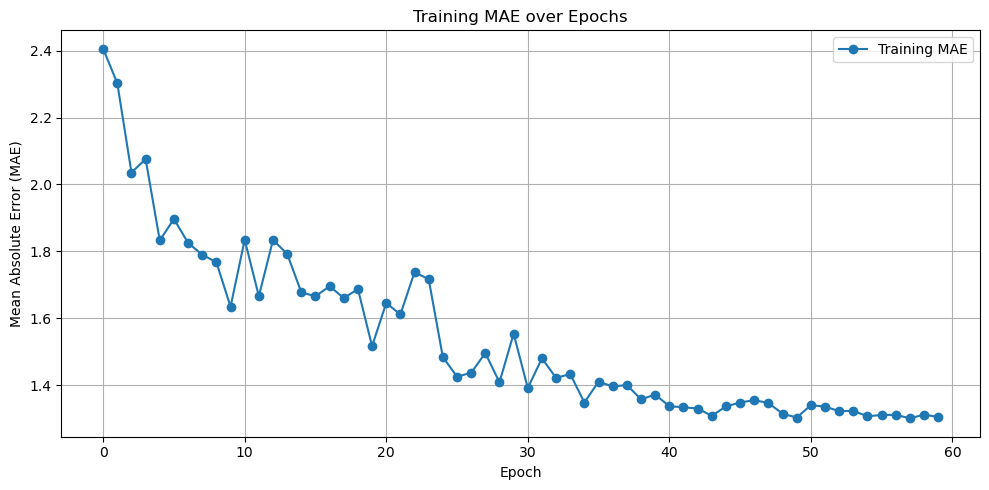

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(epoch_list, val_mae_list, marker='o', label='Training MAE')
plt.title('Training MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [53]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

C:\Users\Xuanhao Zhu\AppData\Local\Temp\ipykernel_37852\296312515.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


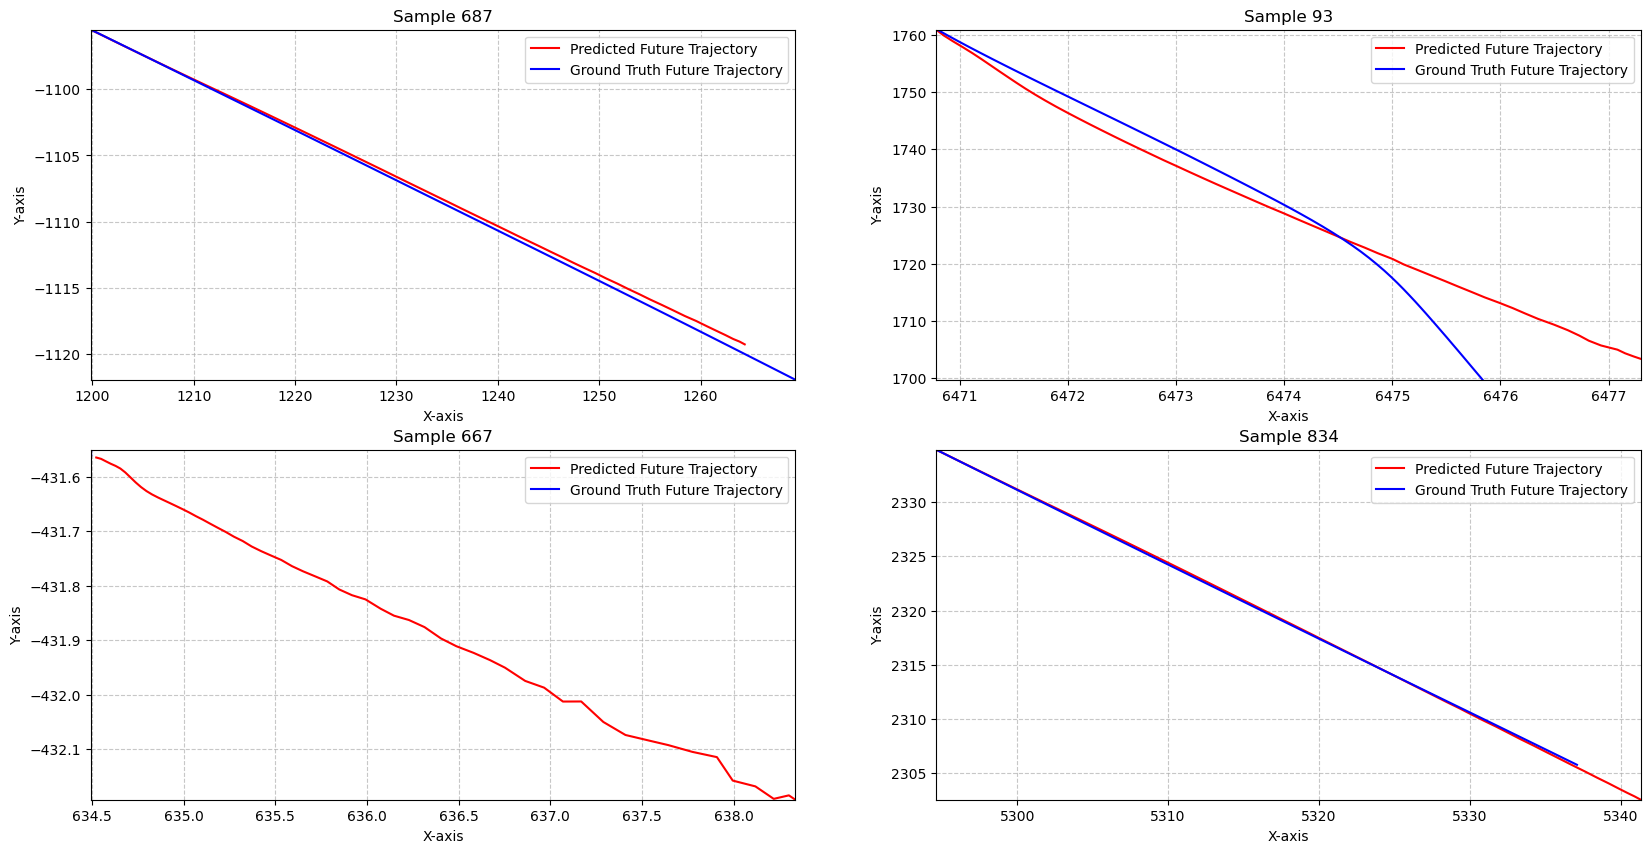

In [65]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B